# Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
### NEW FUNCTION FOR COMBINED ACF/PACF WITH ANNOTATIONS
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [36]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Load in data
df = pd.read_csv('Data/example_time_series.csv')
df

,Date,ts_1,ts_2,ts_3,ts_4,ts_5,ts_6
0,2020-01-05,0.422207,-0.334830,-0.194485,0.304119,0.335330,0.628650
1,2020-01-12,-0.455290,-0.343508,-0.649775,0.385431,0.253175,-0.062857
2,2020-01-19,0.914767,-0.080714,0.264993,0.987436,0.202251,0.474599
3,2020-01-26,0.562761,0.010582,0.827754,0.830760,0.137298,-0.591919
4,2020-02-02,-0.649239,-0.088101,0.178515,-0.827785,0.305798,-0.372528
...,...,...,...,...,...,...,...
195,2023-10-01,-0.180337,0.034521,-3.690399,0.698037,0.730687,-0.901562
196,2023-10-08,-0.607009,-0.126291,-4.297408,-1.720225,0.582334,0.515721
197,2023-10-15,0.616274,-0.242378,-3.681135,2.085681,0.703901,0.801864
198,2023-10-22,-0.443541,-0.226903,-4.124676,-1.755198,0.634631,0.894529


In [5]:
# Make Date a datetime object 
df['Date'] = pd.to_datetime(df['Date'])
# Make Date the index
df = df.set_index('Date')
# We have weekly data so we will set our frequency to W
df.index.freq= "W"

In [6]:
# Split the dataframe into 6 different time series
ts_1 = df['ts_1']
ts_2 = df['ts_2']
ts_3 = df['ts_3']
ts_4 = df['ts_4']
ts_5 = df['ts_5']
ts_6 = df['ts_6']

# Analysis

### ts_1

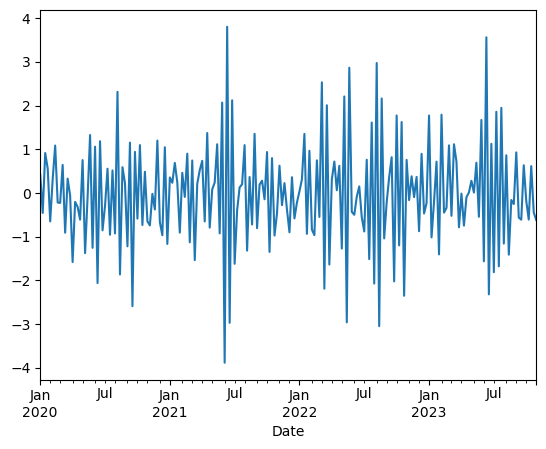

In [7]:
# Plot data
ts_1.plot();

In [8]:
# check for stationarity - ARFuller
get_adfuller_results(ts_1)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-14.612186,1,198,0.0,0.05,True


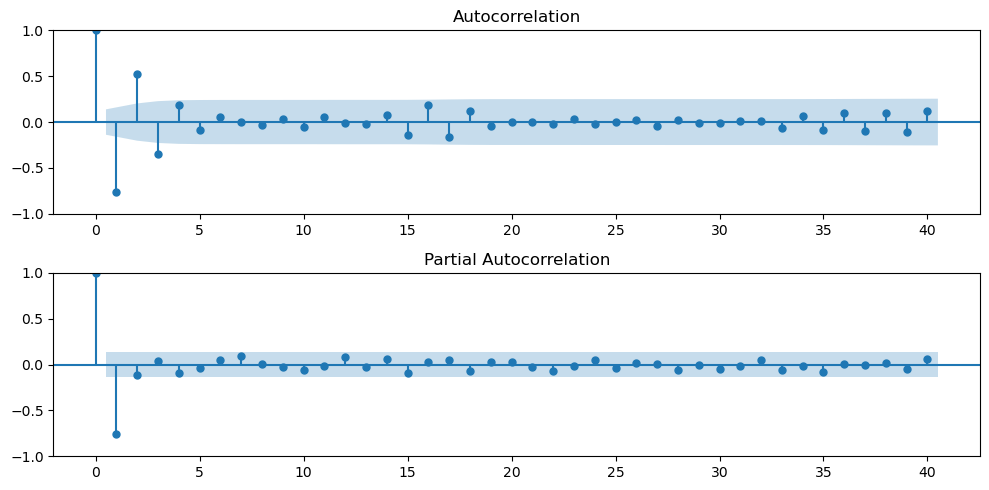

In [9]:
# View the ACF and PACF plots of stationary data
plot_acf_pacf(ts_1);

Conclusions:
- ACF gradually decreases, PACF drops suddenly.
- Data is stationary with no differencing.
- Try AR(1), or (1,0,0)

### ts_2

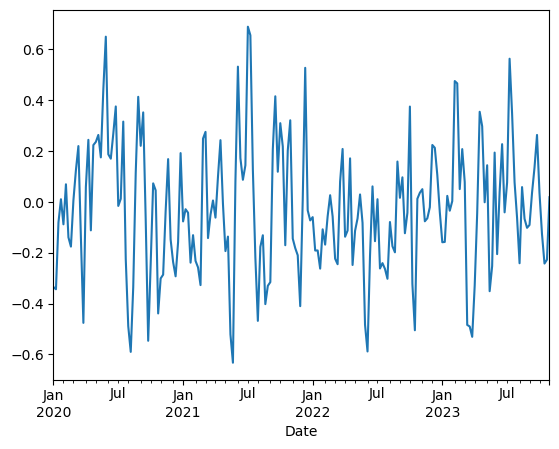

In [10]:
# Plot data
ts_2.plot();

In [11]:
# Check stationarity
get_adfuller_results(ts_2)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-6.139526,5,194,0.0,0.05,True


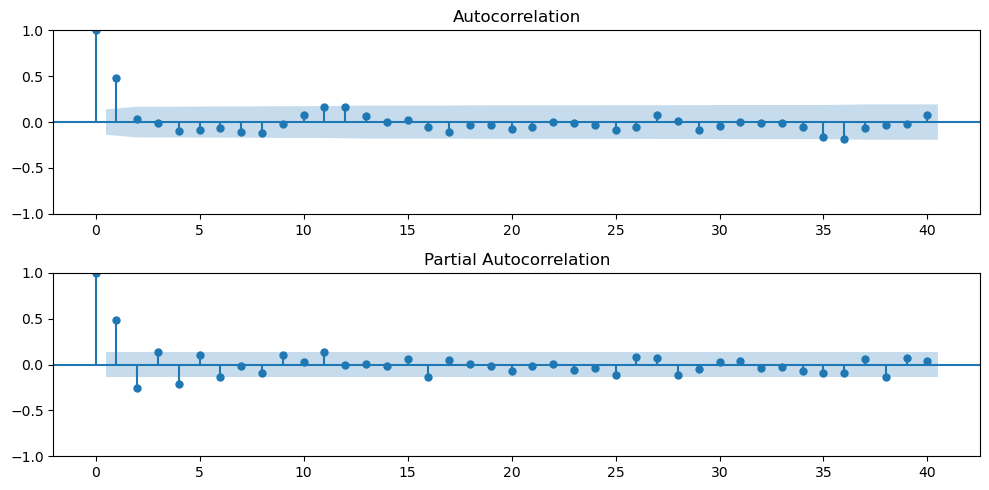

In [12]:
# Data is stationary, plot ACF and PACF
plot_acf_pacf(ts_2);

Conclusions:
- ACF drops off quickly, while PACF drops off gradually.
- Data was stationary with no differencing.
- Suggest the model MA(1) = (0,0,1)

### ts_3

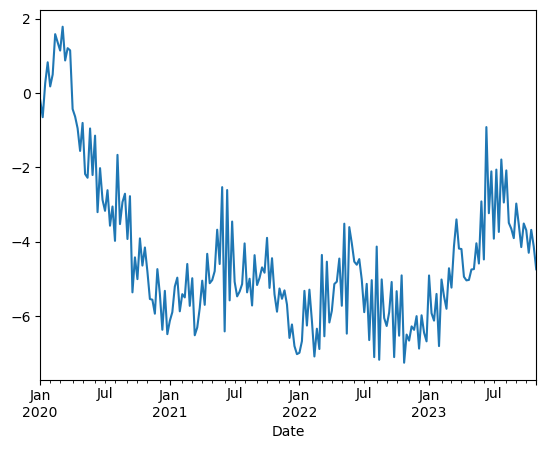

In [13]:
# Plot the data
ts_3.plot();

In [14]:
# Check stationarity
get_adfuller_results(ts_3)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-2.366153,2,197,0.151518,0.05,False


In [15]:
## Data is not stationary, so apply differencing
ts_3_diff = ts_3.diff().dropna()
get_adfuller_results(ts_3_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-14.597695,1,197,0.0,0.05,True


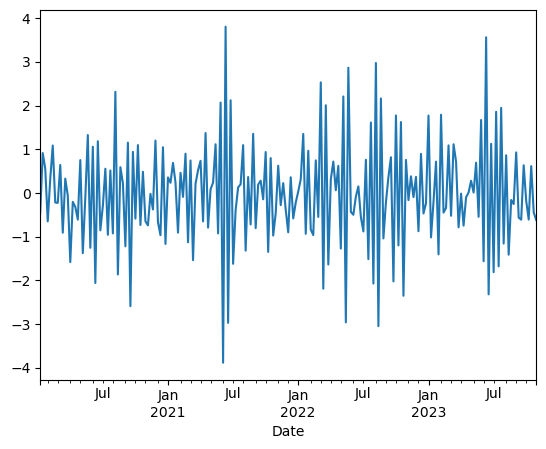

In [16]:
# Replot differenced data
ts_3_diff.plot();

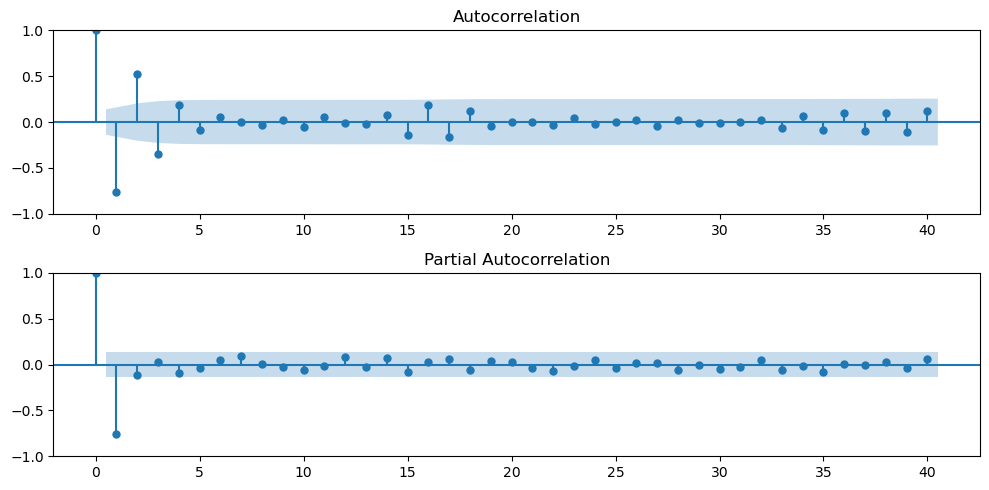

In [17]:
## Data is now stationary
# Check ACF/PACF plots
plot_acf_pacf(ts_3_diff);

Conclusions:
- ACF drops off gradually, while PACF drops suddenly.
- Data was differenced one time to become stationary.
- Suggest the model (1,1,0)

### ts_4

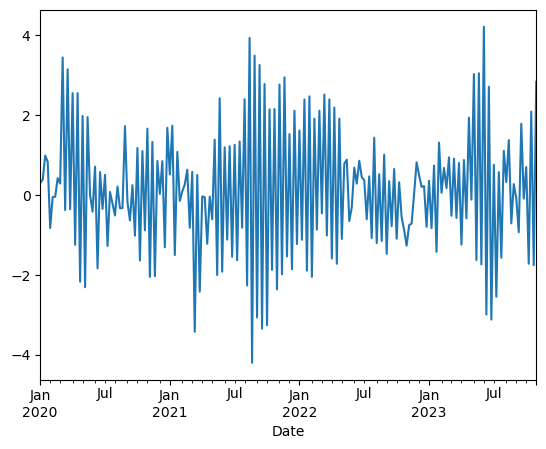

In [18]:
# Plot original data
ts_4.plot();

In [19]:
# Check stationarity
get_adfuller_results(ts_4)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-6.825134,1,198,0.0,0.05,True


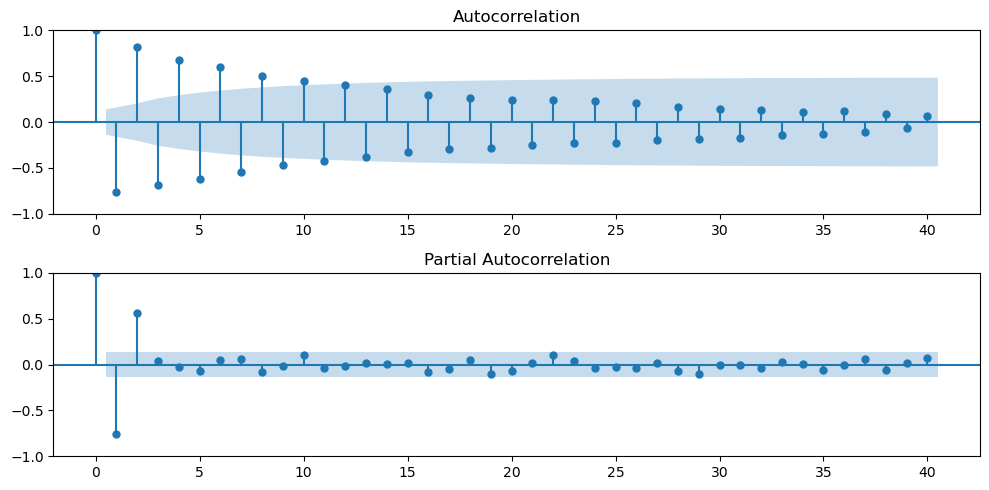

In [20]:
# Data is stationary, check ACF/PACF plots
plot_acf_pacf(ts_4);

Conclusions:
- ACF has a gradual drop off, while PACF has a sudden drop off after lag 2.
- Data is stationary without differencing.
- Try the model AR(2) = (2,0,0)

### ts_5

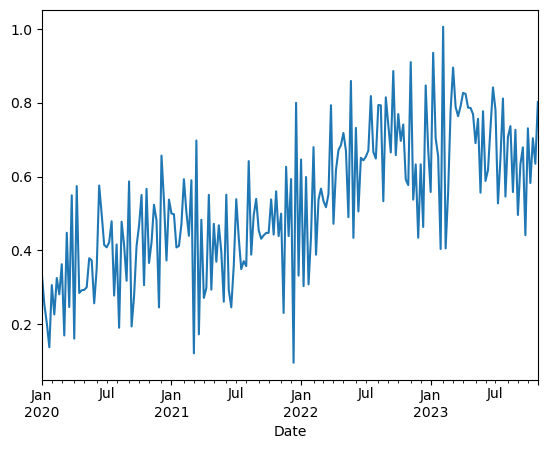

In [21]:
# Plot original data
ts_5.plot();

In [22]:
# Check stationarity
get_adfuller_results(ts_5)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-2.085917,4,195,0.250215,0.05,False


In [23]:
# Data is not stationary, check # of differencings
ts_5_diff = ts_5.diff().dropna()
get_adfuller_results(ts_5_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.465469,3,195,0.0,0.05,True


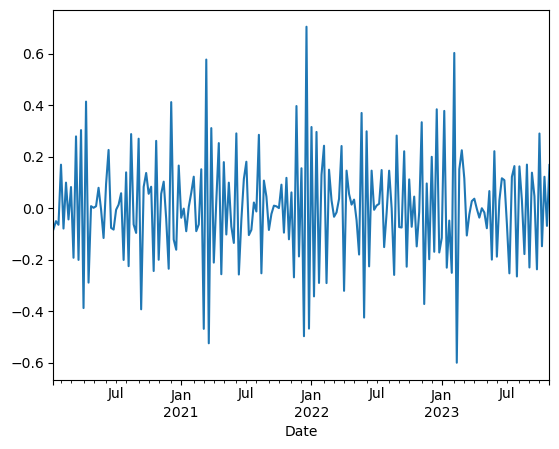

In [24]:
# Replot differenced data
ts_5_diff.plot();

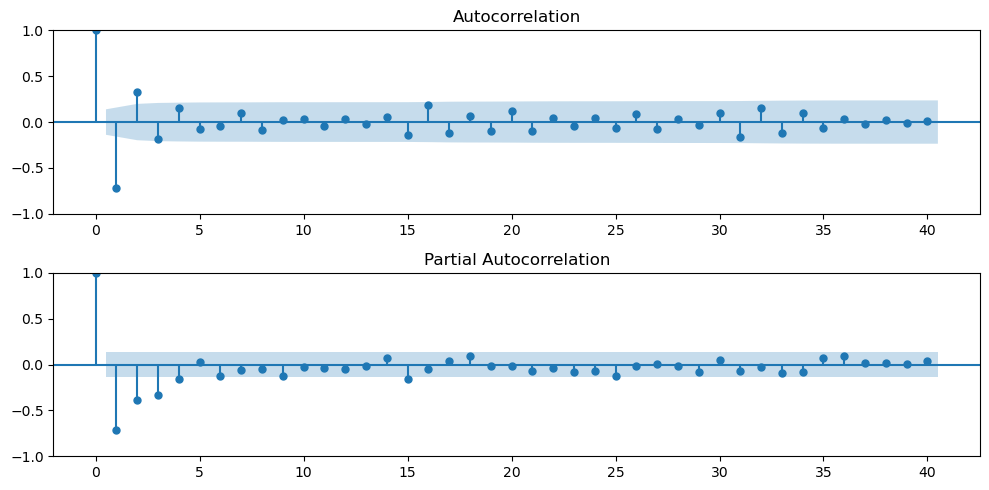

In [25]:
# Check ACF/PACF plots of stationary data
plot_acf_pacf(ts_5_diff);

Conclusion:
- ACR possibly drops off gradually. PACF does drop gradually.
- Data took one differencing to become stationary.
- Try ARMA with (1,1,1)
- After this, increase either p or q and see if the coeff is significant or not when fitting the model.

## ts_6

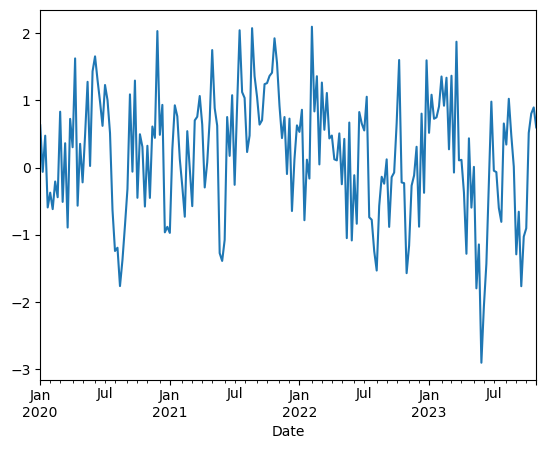

In [26]:
# Plot original data
ts_6.plot();

In [27]:
# Check stationarity
get_adfuller_results(ts_6)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-3.971288,9,190,0.001569,0.05,True


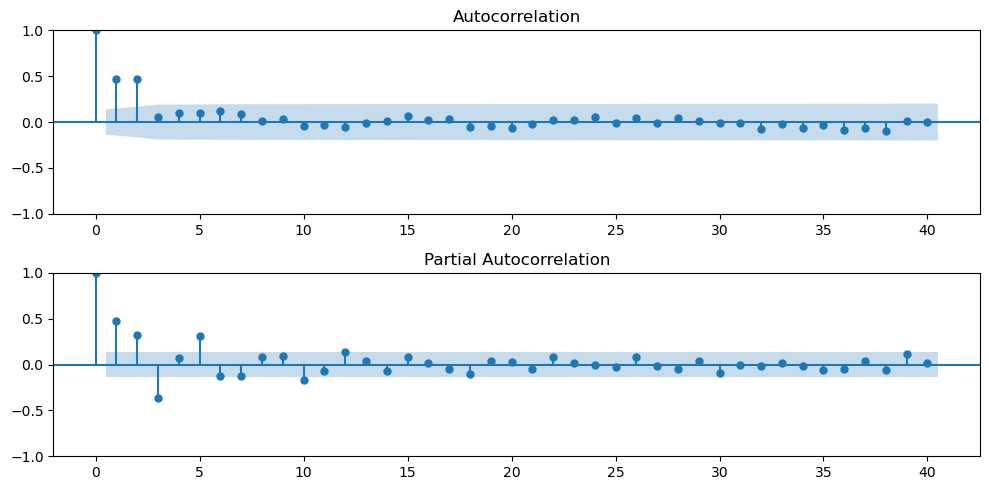

In [28]:
# Check ACF/PACF plots
plot_acf_pacf(ts_6);

Conclusions:
- ACF drops off suddenly after lag 2, while PACF gradually drops.
- Data was stationary without differencing.
- Suggested model is MA(2) = (0,0,2)

# ARIMA Models - Practice

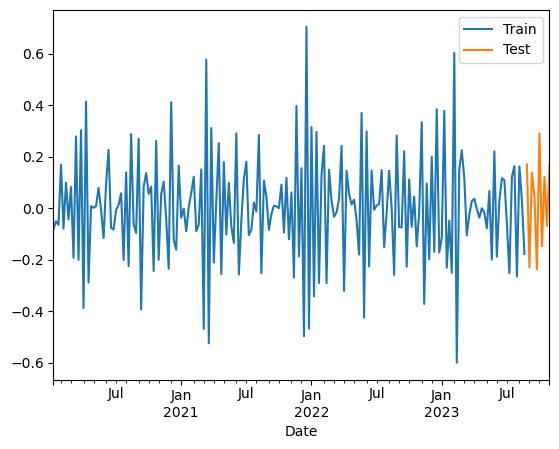

In [29]:
## 1. Train test split the data with test size of 10 weeks
# Set # of test lags
n_test_lags = 10

# Visualize TTS
train, test = train_test_split(ts_5_diff, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [31]:
## 2. Fit an ARIMA model using pdq determined in earlier analysis
# Assign values
p=1
d=1
q=1

# Define and fit model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

In [33]:
## 3. Check model summary and diagnostic plots
# Model summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ts_5   No. Observations:                  189
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  89.864
Date:                Wed, 06 Dec 2023   AIC                           -173.728
Time:                        14:01:17   BIC                           -164.018
Sample:                    01-12-2020   HQIC                          -169.794
                         - 08-20-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7128      0.050    -14.170      0.000      -0.811      -0.614
ma.L1         -1.0000    128.568     -0.008      0.994    -252.988     250.988
sigma2         0.0217      2.788      0.008      0.994      -5.442       5.485
===================================================================================
Ljung-Box (L1) (Q):                  14.80   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.00   Prob(JB):                         0.64
Heteroskedasticity (H):               1.31   Skew:                             0.17
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

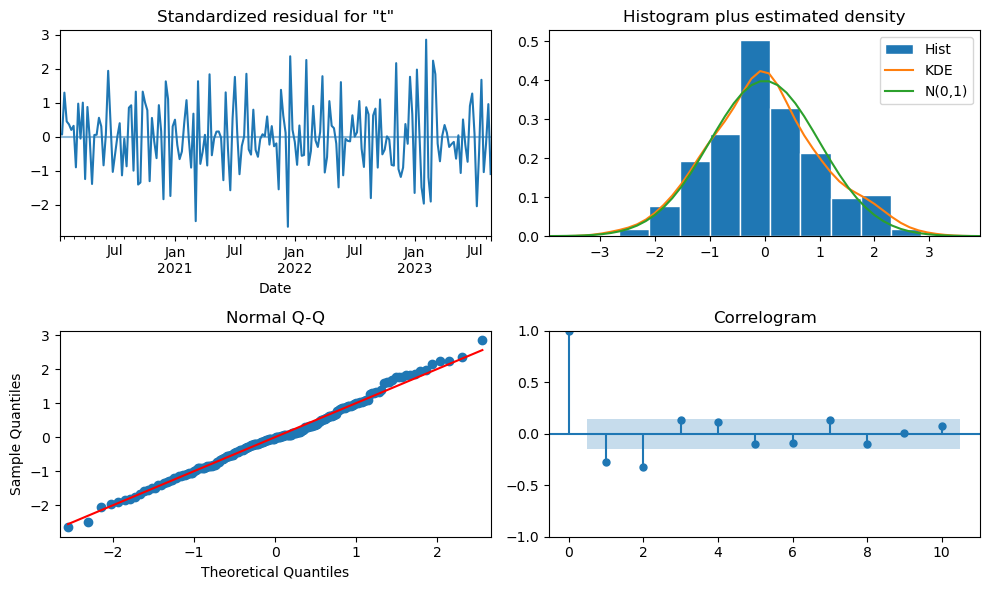

In [34]:
# Diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

- There are still indications on the Correlogram that this model is not capturing as much as it could from the data.

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

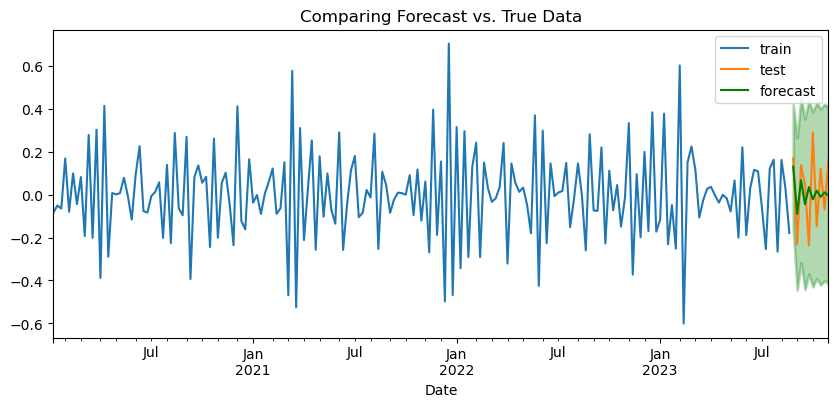

In [38]:
## 4. Extract a forecast from the model
# Create df of forecast summary
forecast_df = arima_model.get_forecast(len(test)).summary_frame()
# Plot forecast alongside true values
plot_forecast(train, test, forecast_df)

In [41]:
# 5. Evaluate regression metrics
regression_metrics_ts(test, forecast_df['mean'])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 0.147
- MSE = 0.029
- RMSE = 0.169
- R^2 = 0.064
- MAPE = 99.33%


In [45]:
## 6. Try a loop to test various orders of (p,d,q)

## Create list of values to test
# Import tools
import itertools
# Define value range for values of p,d,q
p_vals = range(0,3)
d_vals = [1]
q_vals = range(0,3)

# Create combinations of pdq for testing
pdq_to_test = list(itertools.product(p_vals, d_vals, q_vals))
pdq_to_test

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [46]:
## Test the models with a loop

# Define starting AIC
best_aic = float('inf')
# Define baseline pdq
best_pdq = (0,0,0)

# Loop through each variation
for pdq in pdq_to_test:
    
    model = tsa.ARIMA(train, order=pdq)
    result = model.fit()
    print(pdq, result.aic)

    # If lower, update metrics
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print best orders and AIC score
print('Best AIC:', best_aic)
print('Best pdq:', best_pdq)

(0, 1, 0) 182.0020701284433
(0, 1, 1) -42.183565700044


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2) -202.77131538656803
(1, 1, 0) -9.910653908361098
(1, 1, 1) -173.72773013775299


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2) -233.36108650416412
(2, 1, 0) -71.43220756015118


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 1) -201.6241494938211
(2, 1, 2) -231.4008735874931
Best AIC: -233.36108650416412
Best pdq: (1, 1, 2)


C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


- Best metrics from test:
    - AIC: -233.36
    - PDQ: 1,1,2

In [47]:
## 7. Select final model
# Build model with best AIC
p=1
d=1
q=2

# Define and fit model
chosen_model = tsa.ARIMA(train, order=(p,d,q)).fit()

C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Malue\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
# Get summary
chosen_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ts_5   No. Observations:                  189
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 120.681
Date:                Wed, 06 Dec 2023   AIC                           -233.361
Time:                        14:21:12   BIC                           -220.415
Sample:                    01-12-2020   HQIC                          -228.116
                         - 08-20-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4507      0.068     -6.612      0.000      -0.584      -0.317
ma.L1         -1.7750      1.748     -1.015      0.310      -5.201       1.651
ma.L2          0.7750      1.346      0.576      0.565      -1.863       3.413
sigma2         0.0153      0.027      0.566      0.571      -0.038       0.068
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.86   Prob(JB):                         0.45
Heteroskedasticity (H):               1.31   Skew:                            -0.22
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

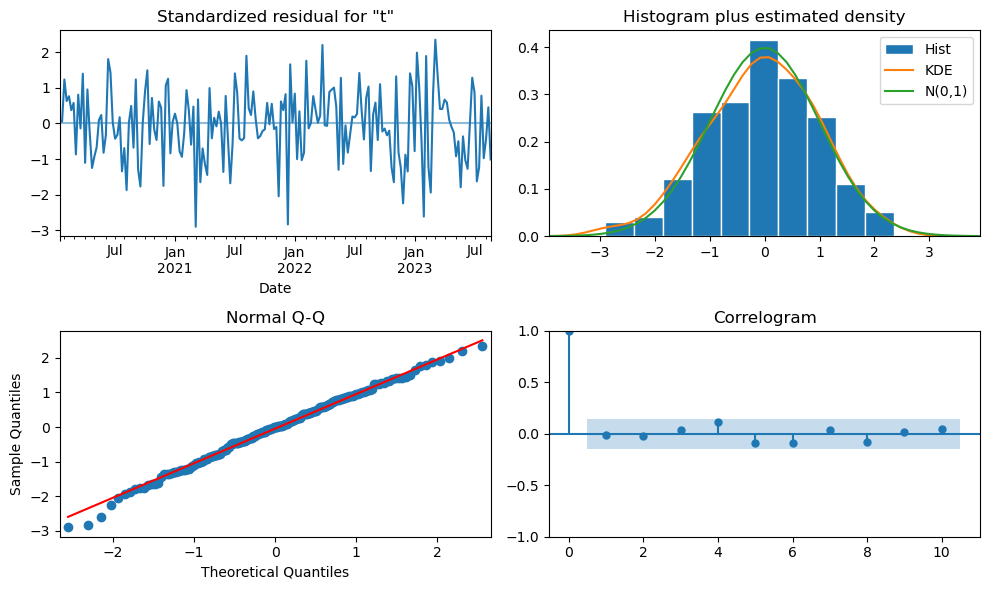

In [49]:
# Show diagnostic plots
fig = chosen_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 0.137
- MSE = 0.025
- RMSE = 0.159
- R^2 = 0.177
- MAPE = 88.39%


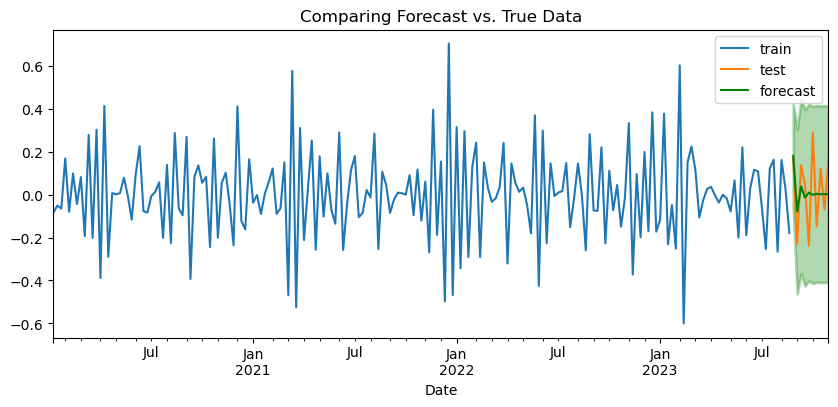

In [50]:
# Plot forecast
chosen_df = chosen_model.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, chosen_df)
regression_metrics_ts(test, chosen_df['mean'])